### Notebook con el Analisis Exploratorio de los datos (EDA). 

#### Importando librerías

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


#### Lectura de los datos. 

Dado el volumen de los mismos, para la realización del EDA se cogerá una muestra aleatoria con el 25% de la base original.

In [2]:
df = pd.read_csv('/Users/mac/Desktop/DataScience/LANA/credit_card_transactions-ibm_v2.csv')
df = df.sample(frac = 0.25, random_state=34)

In [3]:
df.rename(columns={'Merchant State': 'MerchantState',
                   'Merchant City':'MerchantCity'}, inplace=True)

#### Visualización del contenido de nuestra base de datos.

In [4]:
df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'MerchantCity', 'MerchantState', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [5]:
df.head(3)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,MerchantCity,MerchantState,Zip,MCC,Errors?,Is Fraud?
4664527,396,1,2006,10,12,09:35,$40.62,Swipe Transaction,-1288082279022882052,Nashport,OH,43830.0,5499,NaN,No
14430671,1178,1,2001,1,21,21:24,$60.00,Swipe Transaction,-4282466774399734331,Clinton,OH,44216.0,4829,NaN,No
4250077,352,0,2013,9,14,11:23,$0.53,Swipe Transaction,6666504894937430109,Las Vegas,NV,89142.0,5499,NaN,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096725 entries, 4664527 to 5822177
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   User           int64  
 1   Card           int64  
 2   Year           int64  
 3   Month          int64  
 4   Day            int64  
 5   Time           object 
 6   Amount         object 
 7   Use Chip       object 
 8   Merchant Name  int64  
 9   MerchantCity   object 
 10  MerchantState  object 
 11  Zip            float64
 12  MCC            int64  
 13  Errors?        object 
 14  Is Fraud?      object 
dtypes: float64(1), int64(7), object(7)
memory usage: 744.2+ MB


Variable objetivo de tipo "object". La transformamos en tipo numérico renombrándola a "target" y estudiamos si nuestra base de datos está balanceada. 

In [ ]:
df['target'] = np.where(df['Is Fraud?'] == 'No', 0, 1)
print(df['target'].value_counts(normalize=1))

df.drop('Is Fraud?', axis = 1, inplace = True)

#####  Resultado: 
+ Los datos indican que, el 99.88% de la base tiene un valor de nuestro target igual a 0. Expresado de otra manera; sólo en el 0.12% de las transacciones se ha cometido fraude. 

#### Missing data de la base de datos.

In [10]:
(df.isnull().mean()*100).sort_values(ascending= False)

Errors?          98.404488
Zip              11.780505
MerchantState    11.141966
target            0.000000
MCC               0.000000
MerchantCity      0.000000
Merchant Name     0.000000
Use Chip          0.000000
Amount            0.000000
Time              0.000000
Day               0.000000
Month             0.000000
Year              0.000000
Card              0.000000
User              0.000000
dtype: float64

#### Resultado: 
+ Se observa que el 98.4% de la variable "Errors?" no tiene datos. Esta variable se eliminará del estudio.

#### Cardinalidad de las variables:

In [11]:
for col in df.columns:
    print('{} has {} unique values'.format(col, df[col].nunique()))


User has 2000 unique values
Card has 9 unique values
Year has 30 unique values
Month has 12 unique values
Day has 31 unique values
Time has 1440 unique values
Amount has 62061 unique values
Use Chip has 3 unique values
Merchant Name has 66119 unique values
MerchantCity has 12384 unique values
MerchantState has 216 unique values
Zip has 24987 unique values
MCC has 109 unique values
Errors? has 21 unique values
target has 2 unique values


#### Analisis de las variables de  la base de datos.

Para automatizar el proceso, se crea la siguiente función:

In [78]:
def feature_description(df, feature, plot_figure, ordered):
    
    print('Datos sobre la variable:')
    print('\n')
    print('    Cardinalidad: ',df[feature].nunique())
    print('    Valores que toma la variable: ',df[feature].unique())
    print('    Missing data: ',df[feature].isna().mean())
    print('\n')

    # Distribución de porcentanje de fraude en la muestra para la feature seleccionada
    mean_vals = df.groupby(feature)['target'].mean()
    n_mean_vals = df.groupby(feature)['target'].mean()/df['target'].mean()
    n_counts = df.groupby(feature)['target'].count() 

    # Lo pasamos a un DataFrame:
    df_temp = pd.DataFrame()
    df_temp['mean_target'] = mean_vals
    df_temp['norm_mean_target'] = n_mean_vals
    df_temp['n_counts'] = n_counts
    
    print('Valores de la variable ordenados por tasa de fraude: ')
    print('\n')
    print(df_temp.sort_values(by='norm_mean_target', ascending=False).head(20).round(3))
    
    
    if plot_figure == 'yes':
        # Figura de la distribución de la variable
        plt.figure(figsize = (15,5))
        sns.countplot(x = feature, data = df)
        plt.grid()
        plt.xlabel(feature)
        plt.yscale('log')
        plt.title('Distribucion de ' + feature);

        print('\n')
        print('\n')

        # Figura de la distribución del porcentaje de Fraude
        if ordered == 'no':
            plt.figure(figsize = (15,5))
            df_temp.norm_mean_target.plot.bar()
            plt.grid()
            plt.xlabel(feature)
            plt.ylabel('norm_mean_target')
            plt.title('Distribucion Porcentaje de Fraude');
        else:
            plt.figure(figsize = (15,5))
            df_temp.sort_values('norm_mean_target', ascending = False)['norm_mean_target'].plot.bar()
            plt.grid()
            plt.xlabel(feature)
            plt.ylabel('norm_mean_target')
            plt.title('Distribucion Porcentaje de Fraude');


    


### * User

La variable "User" no se usará en el análisis al tener una función de identificador de usuario.

### * Card

Datos sobre la variable:


    Cardinalidad:  9
    Valores que toma la variable:  [1 0 5 2 4 3 6 7 8]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


   mean_target  norm_mean_target  n_counts
8        0.005             4.245      1342
7        0.003             2.086     11706
6        0.002             1.709     44282
5        0.002             1.469    140699
4        0.002             1.347    326905
3        0.002             1.238    698251
2        0.001             1.129   1075462
1        0.001             0.922   1623734
0        0.001             0.813   2174344






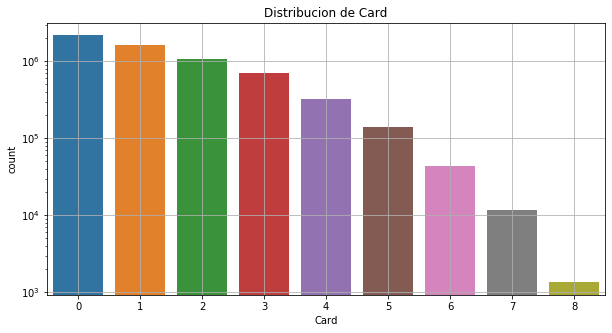

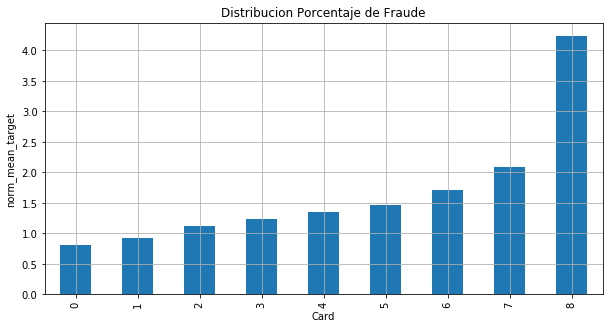

In [13]:
feature = 'Card'
feature_description(df, feature, 'yes', 'no')

#### Resultado: 
+ Se observa una dependencia entre el valor de la variable "Card" con la tasa de fraude (norm_mean_target).

### * Year

Datos sobre la variable:


    Cardinalidad:  30
    Valores que toma la variable:  [2006 2001 2013 2017 2011 2015 2018 2008 2019 1998 2005 2007 2014 2012
 2009 2010 2003 2004 2016 2020 2002 2000 1999 1994 1996 1995 1997 1992
 1993 1991]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


      mean_target  norm_mean_target  n_counts
2008        0.003             2.465    306318
2010        0.003             2.101    372951
2016        0.002             1.646    427250
2015        0.002             1.535    425234
2007        0.002             1.412    266194
2018        0.001             1.144    429519
2013        0.001             1.066    413110
2006        0.001             1.055    226837
2001        0.001             1.041     64880
2019        0.001             1.023    431169
2004        0.001             0.857    149032
1997        0.001             0.784     12461
2012        0.001             0.762    402669
2009        0.001             0.720  

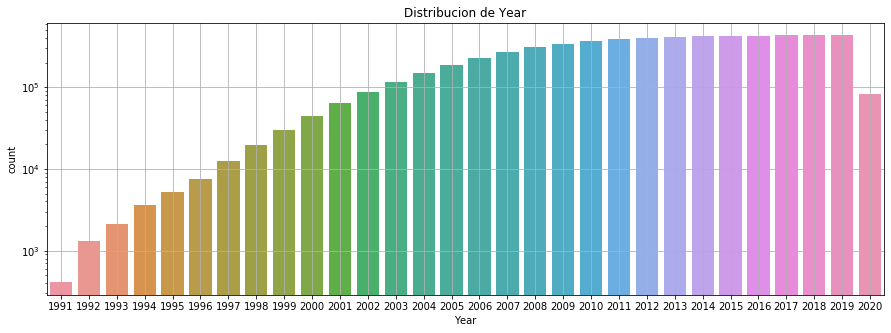

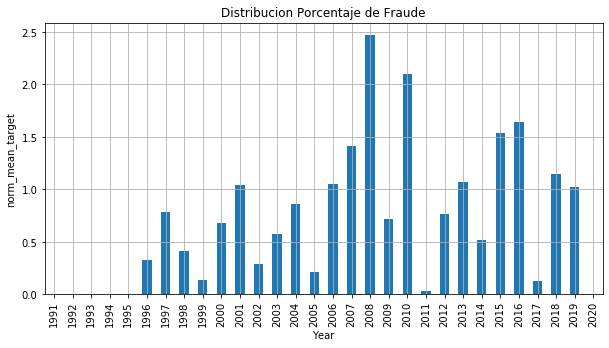

In [19]:
feature = 'Year'
feature_description(df, feature, 'yes', 'no')

#### Resultado: 
+ No se observa una dependencia clara entre el valor de la variable "Year" con la tasa de fraude (norm_mean_target)

### * Month

Datos sobre la variable:


    Cardinalidad:  12
    Valores que toma la variable:  [10  1  9 12  7  5  4 11  6  8  3  2]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


    mean_target  norm_mean_target  n_counts
8         0.001             1.096    517549
10        0.001             1.064    518339
4         0.001             1.061    485477
11        0.001             1.054    507302
12        0.001             1.053    526477
3         0.001             1.044    500513
2         0.001             0.997    490678
9         0.001             0.993    501761
5         0.001             0.948    505416
1         0.001             0.912    535164
7         0.001             0.908    512655
6         0.001             0.871    495394






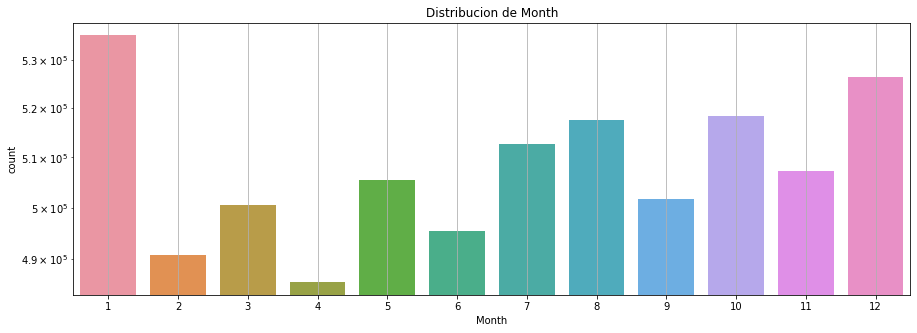

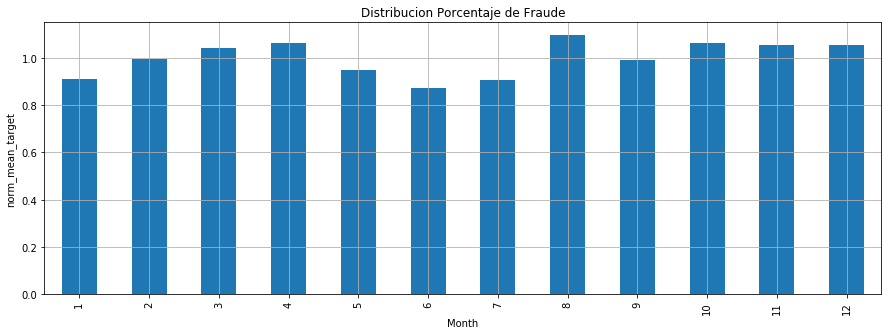

In [32]:
feature = 'Month'
feature_description(df, feature, 'yes', 'no')

#### Resultado: 
+ Aunque se observa cierta dependencia entre el valor de la variable "Month" con la tasa de fraude (norm_mean_target), no será incluida en el análisis porque la distribución indica que es una variable altamente aleatoria en la tasa de fraude. 

#### * Day

Datos sobre la variable:


    Cardinalidad:  31
    Valores que toma la variable:  [12 21 14 30 29 18 24 10 20  1 19 16 26  4 17  5  2  3 28  9 27 15 23 22
  8  7  6 11 13 31 25]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


    mean_target  norm_mean_target  n_counts
12        0.002             1.240    198926
28        0.001             1.127    202950
6         0.001             1.122    199414
29        0.001             1.092    181754
7         0.001             1.079    202788
31        0.001             1.067    116656
21        0.001             1.063    203666
5         0.001             1.057    199436
22        0.001             1.053    200079
26        0.001             1.053    199397
2         0.001             1.042    199154
16        0.001             1.037    198494
19        0.001             1.022    199843
18        0.001             1.019    201316
8         0.001             0.991    200321
3         0.001             0.990  

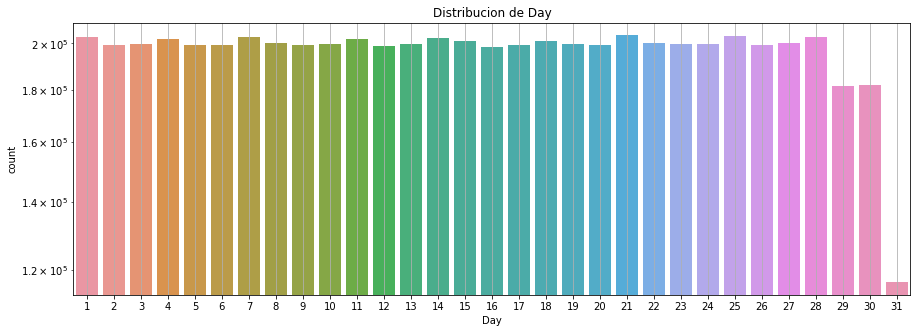

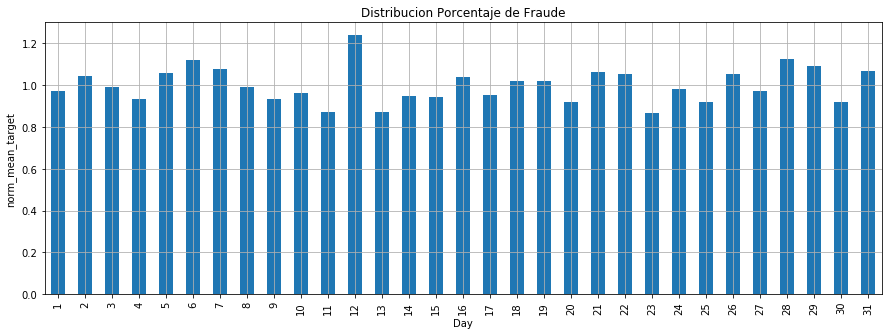

In [23]:
feature = 'Day'
feature_description(df, feature, 'yes', 'no')

#### Resultado: 

+ Aunque se observa cierta dependencia entre el valor de la variable "Day" con la tasa de fraude (norm_mean_target), no será incluida en el análisis porque la distribución indica que es una variable altamente aleatoria en la tasa de fraude. 

#### * Time

Dado que se desconoce si todas las horas refieren al mismo uso horario, esta variable no será incluida en el análisis. 

#### * Amount

Conversión de la variable a tipo numérico:

In [33]:
def trim_dollar_sign(x):
    return str(x)[1:]

df['Amount'] = df['Amount'].apply(trim_dollar_sign)
df['Amount'] = df['Amount'].astype(float)

In [36]:
feature = 'Amount'
feature_description(df, feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  62060
    Valores que toma la variable:  [4.06200e+01 6.00000e+01 5.30000e-01 ... 1.12483e+03 5.82990e+02
 8.25860e+02]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


         mean_target  norm_mean_target  n_counts
1542.77          1.0           813.765         1
1022.58          1.0           813.765         1
382.69           1.0           813.765         1
335.72           1.0           813.765         1
617.53           1.0           813.765         1
295.17           1.0           813.765         1
469.15           1.0           813.765         1
382.04           1.0           813.765         1
1187.76          1.0           813.765         1
795.83           1.0           813.765         1
546.79           1.0           813.765         1
333.08           1.0           813.765         1
456.20           1.0           813.765         1
1024.62          1.0           813.765         1
600.01           1

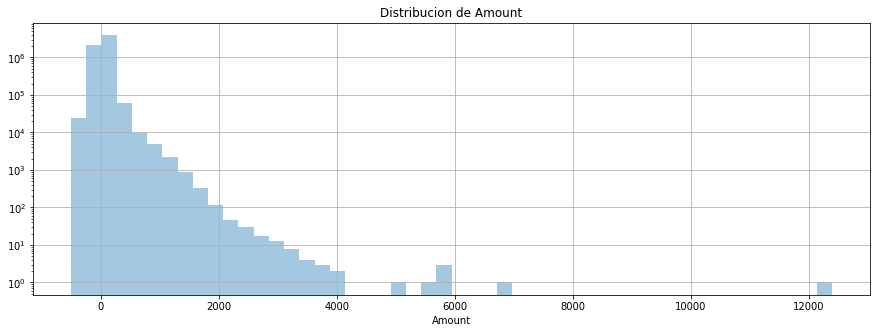

In [37]:
plt.figure(figsize = (15,5))
sns.distplot(df[feature], kde = False)
plt.grid()
plt.xlabel(feature)
plt.yscale('log')
plt.title('Distribucion de ' + feature);

División de la muestra en grupos y estudio de la tasa de fraude en cada uno de ellos.

In [162]:
n_bins = 10 # this number was crafted by hand

df['amount_qtl'], qtl = pd.qcut(df['Amount'], q=n_bins, labels=False, retbins=True, duplicates='drop')
df['amount_qtl'] = df['amount_qtl']+1
df['amount_qtl'] = df['amount_qtl'].fillna(value=0)
df['amount_qtl'] = df['amount_qtl'].astype(int)
df.groupby('amount_qtl')['target'].mean().sort_index().round(5)



amount_qtl
1     0.00113
2     0.00073
3     0.00067
4     0.00067
5     0.00061
6     0.00068
7     0.00084
8     0.00115
9     0.00140
10    0.00440
Name: target, dtype: float64

Text(0, 0.5, '#')

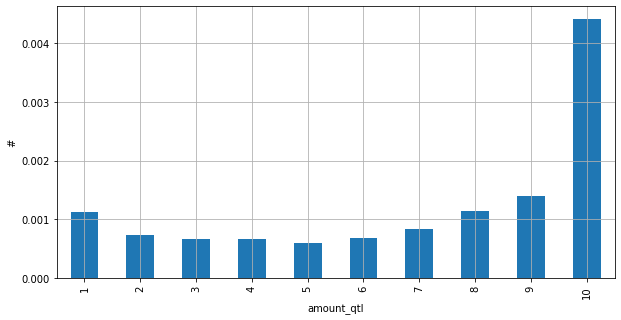

In [164]:
plt.figure(figsize = (10, 5))
df.groupby('amount_qtl')['target'].mean().sort_index().plot.bar()
plt.grid()
plt.ylabel('#')

#### Resultado: 

+ Se observa dependencia entre el valor de la variable "Amount" con la tasa de fraude ('target). Dado que es una variable continua, he decidido agrupar esta variable en 10 intervalos para agilizar el entrenamiento del modelo. 

+ Durante la creación del Pipeline de transformación de datos, se usará un número de bins = 10. 

##### * Use Chip

In [34]:
df['Use Chip'].value_counts(normalize=1)

Swipe Transaction     0.631265
Chip Transaction      0.257621
Online Transaction    0.111113
Name: Use Chip, dtype: float64

Datos sobre la variable:


    Cardinalidad:  3
    Valores que toma la variable:  ['Swipe Transaction' 'Chip Transaction' 'Online Transaction']
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


                    mean_target  norm_mean_target  n_counts
Online Transaction        0.007             5.484    677428
Chip Transaction          0.001             0.619   1570647
Swipe Transaction         0.000             0.366   3848650






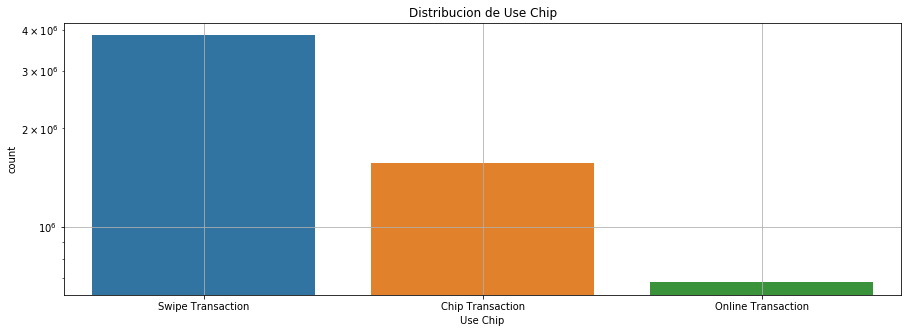

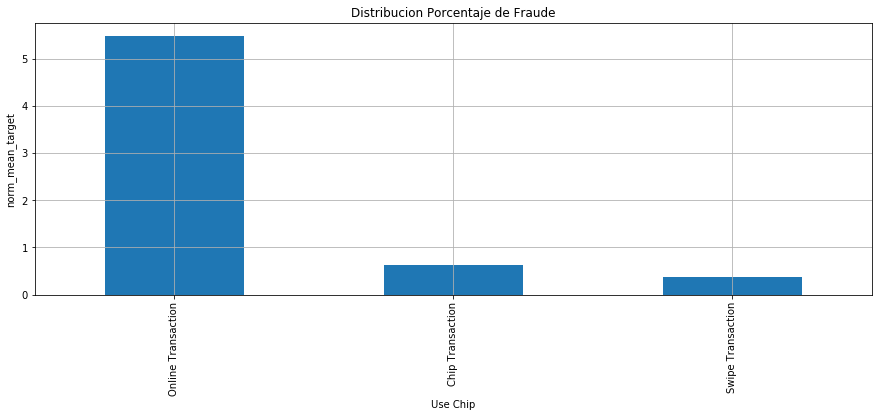

In [35]:
feature = 'Use Chip'
feature_description(df, feature, 'yes', 'yes')

#### Resultado: 
+ Se observa una dependencia entre el valor de la variable "Use Chip" con la tasa de fraude (norm_mean_target)

##### * Merchant Name

In [60]:
feature = 'Merchant Name'
feature_description(df, feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  66119
    Valores que toma la variable:  [-1288082279022882052 -4282466774399734331  6666504894937430109 ...
  1006665632325659224  1390603428376220307 -4634569769300975213]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


                      mean_target  norm_mean_target  n_counts
-8618150378409712628          1.0           813.765         2
 2270777868938598320          1.0           813.765         1
 4123905909792058248          1.0           813.765         1
 2798864092376852114          1.0           813.765         1
 5995540142155027724          1.0           813.765         1
-8010342361781236301          1.0           813.765         1
-1396694134489308426          1.0           813.765         1
-4808614709787878927          1.0           813.765         1
-6537935567366734304          1.0           813.765         1
 175564711024323037           1.0           813.765         1
-6896261553082207

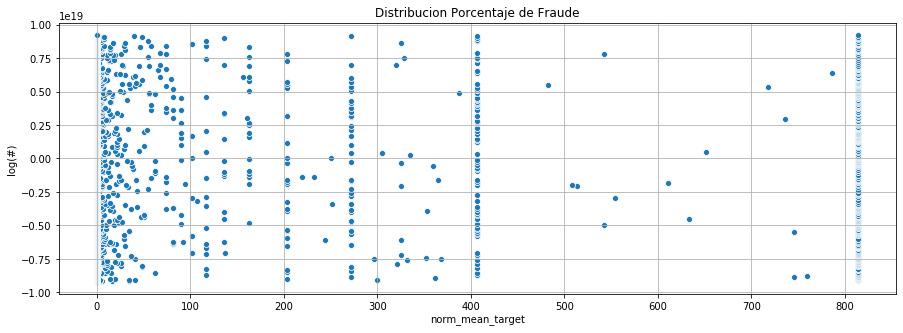

In [61]:
df_temp = pd.DataFrame()
df_temp['mean_target'] = df.groupby(feature)['target'].mean()
df_temp['norm_mean_target'] = df.groupby(feature)['target'].mean()/df['target'].mean()
df_temp['n_counts'] = df.groupby(feature)['target'].count() 

plt.figure(figsize = (15,5))
sns.scatterplot(x = 'norm_mean_target', y = df_temp.index, data = df_temp)
plt.grid()
plt.xlabel('norm_mean_target')
plt.ylabel('log(#)')
#plt.yscale('log')
plt.title('Distribucion Porcentaje de Fraude');

#### Resultado: 
+ No se observa una dependencia entre el valor de la variable "Merchant Name" con la tasa de fraude (norm_mean_target)

##### * Merchant State

In [62]:
feature = 'MerchantState'
feature_description(df, feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  216
    Valores que toma la variable:  ['OH' 'NV' 'CA' 'SC' nan 'MO' 'IL' 'PA' 'NY' 'WI' 'AL' 'KY' 'TX' 'MA' 'AR'
 'FL' 'GA' 'RI' 'NC' 'MD' 'VA' 'IN' 'MS' 'WA' 'NJ' 'TN' 'NM' 'AZ' 'MI'
 'IA' 'OK' 'United Kingdom' 'WV' 'MN' 'ID' 'LA' 'Switzerland' 'ME' 'KS'
 'Spain' 'Canada' 'UT' 'OR' 'HI' 'VT' 'AK' 'NH' 'CO' 'SD' 'MT' 'CT'
 'Germany' 'DE' 'NE' 'Mexico' 'ND' 'The Bahamas' 'Pakistan' 'Italy'
 'Dominican Republic' 'Aruba' 'WY' 'India' 'Slovakia' 'Ireland' 'France'
 'Taiwan' 'Thailand' 'DC' 'Finland' 'Hong Kong' 'Norway' 'Ecuador'
 'Hungary' 'Japan' 'Russia' 'China' 'Philippines' 'Portugal' 'Nigeria'
 'Brazil' 'Serbia' 'Mongolia' 'Costa Rica' 'South Korea' 'Jamaica'
 'Czech Republic' 'Netherlands' 'Poland' 'Barbados' 'Saudi Arabia'
 'Greece' 'Iceland' 'Australia' 'Argentina' 'Algeria' 'Israel' 'Peru'
 'South Africa' 'Indonesia' 'Colombia' 'Austria' 'Belgium'
 'United Arab Emirates' 'Honduras' 'Sweden' 'Singapore' 'Denmark'
 "Cote d'Ivoire" 'Tur

#### Análisis de estos resultados. 

División de la muestra en estados de EEUU y el resto de paises.

In [63]:
def lenth_states(x):
    return len(x)

In [64]:
df['length_MerchantState'] = df['MerchantState'].astype(str).apply(lenth_states)

df['USMerchantState'] = 0
df.loc[df.query("length_MerchantState == 2").index, 'USMerchantState'] = 1
print(df['USMerchantState'].value_counts())

1    5378500
0     718225
Name: USMerchantState, dtype: int64


##### EEUU States:

In [65]:
# EEUU States:

print('Porcentaje de estados de EEUU en la base de datos: {}'
      .format(100*len(df[df['USMerchantState']== 1])/len(df)))
print('\n')

print('Cardinalidad: {}'.format(df[df['USMerchantState']== 1]['MerchantState'].nunique()))
print('\n')

print('Valores que toma la variable: {}'.format(df[df['USMerchantState']== 1]['MerchantState'].unique()))
print('\n')

print('Porcentaje de fraude: {}'.format(df[df['USMerchantState']== 1]['target'].mean() / df['target'].mean()))

Porcentaje de estados de EEUU en la base de datos: 88.2194948927498


Cardinalidad: 52


Valores que toma la variable: ['OH' 'NV' 'CA' 'SC' 'MO' 'IL' 'PA' 'NY' 'WI' 'AL' 'KY' 'TX' 'MA' 'AR'
 'FL' 'GA' 'RI' 'NC' 'MD' 'VA' 'IN' 'MS' 'WA' 'NJ' 'TN' 'NM' 'AZ' 'MI'
 'IA' 'OK' 'WV' 'MN' 'ID' 'LA' 'ME' 'KS' 'UT' 'OR' 'HI' 'VT' 'AK' 'NH'
 'CO' 'SD' 'MT' 'CT' 'DE' 'NE' 'ND' 'WY' 'DC' 'AA']


Porcentaje de fraude: 0.1930582382913998


Datos sobre la variable:


    Cardinalidad:  52
    Valores que toma la variable:  ['OH' 'NV' 'CA' 'SC' 'MO' 'IL' 'PA' 'NY' 'WI' 'AL' 'KY' 'TX' 'MA' 'AR'
 'FL' 'GA' 'RI' 'NC' 'MD' 'VA' 'IN' 'MS' 'WA' 'NJ' 'TN' 'NM' 'AZ' 'MI'
 'IA' 'OK' 'WV' 'MN' 'ID' 'LA' 'ME' 'KS' 'UT' 'OR' 'HI' 'VT' 'AK' 'NH'
 'CO' 'SD' 'MT' 'CT' 'DE' 'NE' 'ND' 'WY' 'DC' 'AA']
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


    mean_target  norm_mean_target  n_counts
OH        0.001             4.011    223859
AK        0.000             1.827      4613
HI        0.000             1.690     34920
WY        0.000             1.594      5289
NE        0.000             1.568     24193
MT        0.000             1.455     14489
CA        0.000             1.347    647989
TN        0.000             1.279    125275
OR        0.000             1.184     42734
MI        0.000             1.146    154443
OK        0.000             1.136     81666
NJ        0.000             1.123    15759

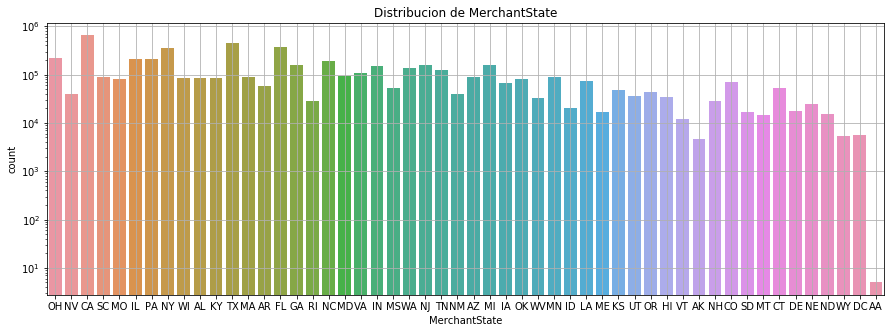

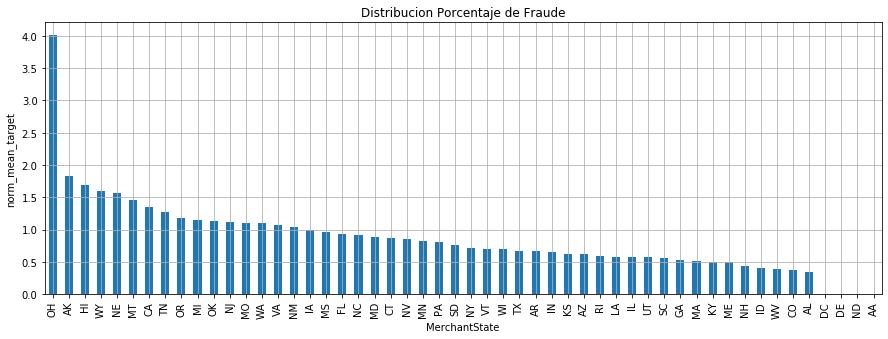

In [66]:
df_temp = df[df['USMerchantState']==1]
feature = 'MerchantState'
feature_description(df_temp, feature, 'yes', 'yes')

In [106]:
df[df['USMerchantState']==1].isnull().sum()

User                          0
Card                          0
Year                          0
Month                         0
Day                           0
Time                          0
Amount                        0
Use Chip                      0
Merchant Name                 0
MerchantCity                  0
MerchantState                 0
Zip                           0
MCC                           0
Errors?                 5297174
target                        0
length_MerchantState          0
USMerchantState               0
dtype: int64

#### Resultado: 
+ Se observa una clara dependencia de los estados de EEUU con la tasa de fraude (norm_mean_target)

+ Se observa que los datos referentes a los estados de EEUU no presentan missing data, excetuando la variable "Errors?" que será eliminada por su elevado porcentaje de missing data.



#####  NO-EEUU States:

In [67]:
# NO-EEUU:

print('Porcentaje de paises distintos a estados de EEUU en la base de datos: {}'
      .format((100*len(df[df['USMerchantState']== 0])/len(df))))
print('\n')

print('Cardinalidad: {}'.format(df[df['USMerchantState']== 0]['MerchantState'].nunique()))
print('\n')

print('Valores que toma la variable {}'.format(df[df['USMerchantState']== 0]['MerchantState'].unique()))
print('\n')


print('Porcentaje de fraude: {}'.format(df[df['USMerchantState']== 0]['target'].mean() / df['target'].mean()))

Porcentaje de paises distintos a estados de EEUU en la base de datos: 11.780505107250203


Cardinalidad: 164


Valores que toma la variable [nan 'United Kingdom' 'Switzerland' 'Spain' 'Canada' 'Germany' 'Mexico'
 'The Bahamas' 'Pakistan' 'Italy' 'Dominican Republic' 'Aruba' 'India'
 'Slovakia' 'Ireland' 'France' 'Taiwan' 'Thailand' 'Finland' 'Hong Kong'
 'Norway' 'Ecuador' 'Hungary' 'Japan' 'Russia' 'China' 'Philippines'
 'Portugal' 'Nigeria' 'Brazil' 'Serbia' 'Mongolia' 'Costa Rica'
 'South Korea' 'Jamaica' 'Czech Republic' 'Netherlands' 'Poland'
 'Barbados' 'Saudi Arabia' 'Greece' 'Iceland' 'Australia' 'Argentina'
 'Algeria' 'Israel' 'Peru' 'South Africa' 'Indonesia' 'Colombia' 'Austria'
 'Belgium' 'United Arab Emirates' 'Honduras' 'Sweden' 'Singapore'
 'Denmark' "Cote d'Ivoire" 'Turkey' 'New Zealand' 'Egypt' 'Ukraine'
 'Guatemala' 'Vietnam' 'Micronesia' 'Malaysia' 'Luxembourg' 'Romania'
 'Liberia' 'Montenegro' 'Croatia' 'Haiti' 'Tuvalu' 'Kenya' 'Lithuania'
 'Bangladesh' 'Fiji' 'Bosn

In [68]:
df_temp = df[df['USMerchantState']==0]
feature = 'MerchantState'
feature_description(df_temp, feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  164
    Valores que toma la variable:  [nan 'United Kingdom' 'Switzerland' 'Spain' 'Canada' 'Germany' 'Mexico'
 'The Bahamas' 'Pakistan' 'Italy' 'Dominican Republic' 'Aruba' 'India'
 'Slovakia' 'Ireland' 'France' 'Taiwan' 'Thailand' 'Finland' 'Hong Kong'
 'Norway' 'Ecuador' 'Hungary' 'Japan' 'Russia' 'China' 'Philippines'
 'Portugal' 'Nigeria' 'Brazil' 'Serbia' 'Mongolia' 'Costa Rica'
 'South Korea' 'Jamaica' 'Czech Republic' 'Netherlands' 'Poland'
 'Barbados' 'Saudi Arabia' 'Greece' 'Iceland' 'Australia' 'Argentina'
 'Algeria' 'Israel' 'Peru' 'South Africa' 'Indonesia' 'Colombia' 'Austria'
 'Belgium' 'United Arab Emirates' 'Honduras' 'Sweden' 'Singapore'
 'Denmark' "Cote d'Ivoire" 'Turkey' 'New Zealand' 'Egypt' 'Ukraine'
 'Guatemala' 'Vietnam' 'Micronesia' 'Malaysia' 'Luxembourg' 'Romania'
 'Liberia' 'Montenegro' 'Croatia' 'Haiti' 'Tuvalu' 'Kenya' 'Lithuania'
 'Bangladesh' 'Fiji' 'Bosnia and Herzegovina' 'Nauru' 'Myanmar (Burma)'
 'Syria' 

#### Resultado: 

+ Se observa que Fiji, Tuvalu, Algeria, Haiti, Nigeria, Turkey, Italy, Japan, Mexico y la India son los que tienen las mayores tasas de fraude. 
+ El resto de los países tienen una tasa de fraude nula. Sin embrago, la muestra que tenemos para estos países es muy baja para la gran mayoría, del orden de unos pocos cientos de transaciones por cada pais. Debido a esta baja estadísitica, no se considerarán por ahora todos estos países que, por otro lado, solo representan el  12.78% de la base de datos. 
+ Se puede indicar ya que, debido a la tasa de fraude obtenida, se desanconseja la inversión en los países indicados en el primer punto: Fiji, Tuvalu, Algeria, Haiti, Nigeria, Turkey, Italy, Japan, Mexico y la India.

##### * MerchantCity

In [79]:
feature = 'MerchantCity'
feature_description(df.query("USMerchantState == 1"), feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  12243
    Valores que toma la variable:  ['Nashport' 'Clinton' 'Las Vegas' ... 'Temperanceville' 'Seaview'
 'Byfield']
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


                 mean_target  norm_mean_target  n_counts
Cartwright               1.0          4215.125         1
New Deal                 1.0          4215.125         1
Raywick                  1.0          4215.125         1
Carman                   1.0          4215.125         1
Wartrace                 1.0          4215.125         1
Paupack                  1.0          4215.125         1
Butte Des Morts          1.0          4215.125         2
Saint Paul Park          1.0          4215.125         1
Keego Harbor             1.0          4215.125         1
Grantsboro               1.0          4215.125         1
Cascilla                 1.0          4215.125         1
Bingham Canyon           1.0          4215.125         1
Macdona      

#### Transacciones producidas en cada una de las ciudades de los estados de EEUU

In [100]:
df_counts = df.query("USMerchantState == 1").groupby(feature)['target'].count()
df_counts.head()

MerchantCity
Aaronsburg       2
Abbeville     5386
Abbot            2
Abbotsford      13
Abbott           2
Name: target, dtype: int64

In [168]:
round((len(df_counts[df_counts > 100])/12243*100), 3)

26.48

#### Resultado: 

+ Es una variable con una cardinalidad muy alta. Además, se únicamente el 26.48% de las ciudades de EEUU han tenido un número de transacciones mayor a 100 (número escogido como indicatorio de alta estadística). Por este motivo esta variable no será incluida en el análisis. 

##### * MCC

Datos sobre la variable:


    Cardinalidad:  103
    Valores que toma la variable:  [5499 4829 4900 5541 5719 5300 5311 5812 5411 5912 9402 5942 5651 5814
 4214 5310 7995 7538 3596 8011 5947 7542 5970 3640 7230 8099 5813 3771
 4121 7832 3395 5211 5655 4814 7349 7922 5251 3387 5094 4111 5921 8049
 5261 3504 3001 8043 3684 7276 5193 7011 4112 8021 3066 3000 3389 7210
 5661 3393 3722 3509 6300 3256 7549 8931 3359 3174 5732 7393 8111 8062
 5621 7531 8041 5977 3730 7996 3260 7802 3058 3775 3780 3405 5712 5932
 4131 3390 1711 4899 5533 5192 5722 3075 3132 5045 5816 5941 5733 3008
 3005 3009 3006 3144 3007]
    Missing data:  0.0


Valores de la variable ordenados por tasa de fraude: 


      mean_target  norm_mean_target  n_counts
5816        0.106           446.307        85
5733        0.084           354.543       107
5722        0.042           176.682       167
5045        0.025           105.598       479
3006        0.019            78.058       162
5094        0.016            68.76

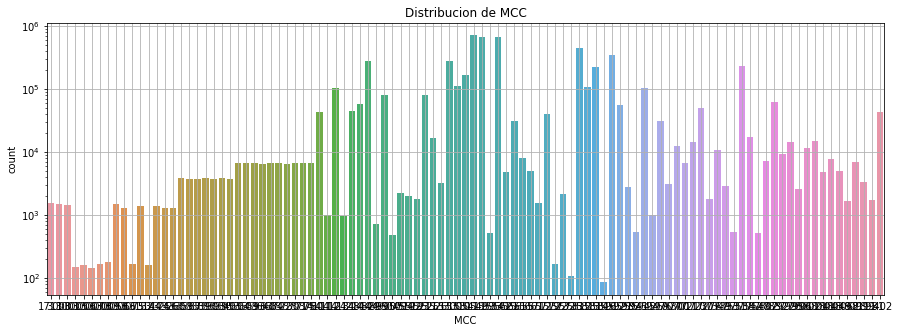

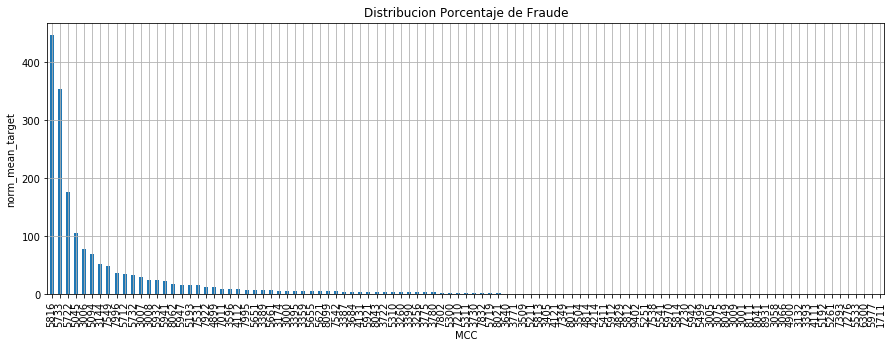

In [105]:
feature = 'MCC'
feature_description(df.query("USMerchantState == 1"), feature, 'yes', 'yes')


#### Resultado: 
+ Se observa una dependencia entre el valor de la variable "MCC" con la tasa de fraude (norm_mean_target). Posteriormente, se agrupará esta variable en función de la tasa de fraude calculada. 

##### * Zip

In [142]:
feature = 'Zip'
feature_description(df, feature, 'no', 'no')

Datos sobre la variable:


    Cardinalidad:  24987
    Valores que toma la variable:  ['43830' '44216' '89142' ... '98644' '1922' '27531']
    Missing data:  0.11780505107250204


Valores de la variable ordenados por tasa de fraude: 


       mean_target  norm_mean_target  n_counts
74402          1.0           813.765         1
60113          1.0           813.765         1
12547          1.0           813.765         1
37116          1.0           813.765         1
18451          1.0           813.765         1
77402          1.0           813.765         2
74731          1.0           813.765         1
61425          1.0           813.765         1
83314          1.0           813.765         1
76050          1.0           813.765         1
71028          1.0           813.765         1
92513          1.0           813.765         1
32240          1.0           813.765         1
32508          1.0           813.765         1
61602          1.0           813.765         1
48320      

In [146]:
df.groupby('Zip').count()['target'].sort_values(ascending=False)

Zip
98516    13902
43830    12301
55024    11189
94606    10853
95076    10831
87121    10559
94131    10543
75023    10489
95687    10064
30101     9690
85711     9520
72450     9458
43228     9433
91606     9327
10463     9237
96792     9067
40299     8963
30022     8956
48146     8790
29229     8786
77056     8717
46256     8638
28056     8576
92886     8202
80013     8143
98021     8122
46307     7940
7922      7928
32137     7863
96706     7787
60411     7717
94804     7652
60084     7573
84004     7389
60085     7381
75042     7310
95111     7272
67212     7228
77064     7107
11211     7096
29579     6937
89148     6935
48235     6771
58103     6700
75227     6697
60153     6639
38606     6634
22015     6618
22003     6538
2151      6534
94598     6511
19146     6501
36695     6443
92105     6427
48375     6375
43512     6314
2840      6303
85226     6292
10950     6287
92887     6267
10456     6181
91752     6170
95624     6148
74501     6130
36693     6075
79912     5991
98023 

In [153]:
df_counts = df.groupby('Zip')['target'].count()
len(df_counts[df_counts > 100])/df['Zip'].nunique()*100

22.203545843838796

#### Resultado: 

+ Dada la alta cardinalidad de la variable "Zip" y que la información contenida en ella tambien se encuentra codificada en la variable "Merchant State", esta variable no será tenida en cuanta en el análisis de fraude, por ahora. 

+ Además, sólo el 22% de los "Zip" tienen más de 100 transacciones.

#### Cálculo una nueva variable "Date"

Esta variable nos ayudará para el estudio de forecasting. 

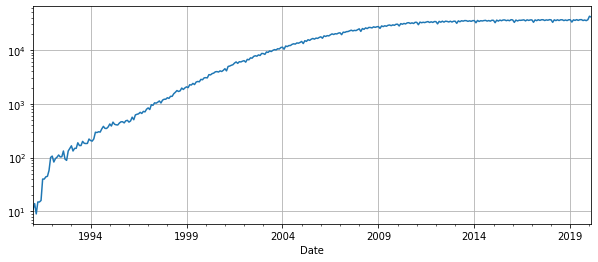

In [120]:
df['Date'] = df['Year'].astype('str') + '-' + df['Month'].astype('str') + '-01'
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

plt.figure(figsize=(10,4))
df.groupby('Date')['target'].count().plot()
plt.grid()
plt.yscale('log')

#### Resultado: 

+ Se observa un aumento del número de transacciones con el tiempo. 